# Gunfire on School Grounds in the United States (1966-2025)

This notebook analyzes incidents of gunfire on or near K-12 school grounds in the United States using the K-12 School Shooting Database (SSDB).

We focus on two research questions:

1. How has the frequency of school gunfire incidents changed over time in the United States?
2. Which states have experienced the highest number of incidents, and how do these trends differ regionally?

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

# Make tables more readable
pd.set_option("display.max_columns", 100)

# ================== PATHS (EDIT THESE IF NEEDED) ==================

# Full path to the Incident Excel file
excel_path = r"D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\3b_Dataset_Incident.xlsx"

# Folder where you want to save CSVs and plots
output_dir = r"D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\Regular codes with Jupyter-2"

print("Excel path:", excel_path)
print("Output dir:", output_dir)

# ================== COLUMN CONFIG ==================

SHEET_NAME = None          # or "Incident" if needed

INCIDENT_ID_COLUMN = "Incident_ID"
DATE_COLUMN        = "Date"
STATE_COLUMN       = "State"


Excel path: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\3b_Dataset_Incident.xlsx
Output dir: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\Regular codes with Jupyter-2


In [2]:
def load_incident_data(path: str, sheet_name=None) -> pd.DataFrame:
    """Load the Incident data from an Excel file."""
    if not os.path.exists(path):
        raise FileNotFoundError(f"File not found: {path}")

    if sheet_name is None:
        df = pd.read_excel(path)
    else:
        df = pd.read_excel(path, sheet_name=sheet_name)

    return df


def prepare_incident_data(df: pd.DataFrame) -> pd.DataFrame:
    """Parse dates, extract Year, and ensure required columns exist."""
    if DATE_COLUMN not in df.columns:
        raise KeyError(
            f"Expected date column '{DATE_COLUMN}' not found. "
            f"Available columns: {list(df.columns)}"
        )

    if STATE_COLUMN not in df.columns:
        raise KeyError(
            f"Expected state column '{STATE_COLUMN}' not found. "
            f"Available columns: {list(df.columns)}"
        )

    if INCIDENT_ID_COLUMN not in df.columns:
        # auto-detect if needed
        for col in df.columns:
            cl = col.lower()
            if "incident" in cl and "id" in cl:
                print(f"Auto-detected incident ID column as '{col}'.")
                df = df.rename(columns={col: INCIDENT_ID_COLUMN})
                break

    if INCIDENT_ID_COLUMN not in df.columns:
        raise KeyError(
            f"Expected incident id column '{INCIDENT_ID_COLUMN}' not found. "
            f"Available columns: {list(df.columns)}"
        )

    # parse dates and extract Year
    df["Date_parsed"] = pd.to_datetime(df[DATE_COLUMN], errors="coerce")
    df["Year"] = df["Date_parsed"].dt.year

    df = df.dropna(subset=["Year"])
    df["Year"] = df["Year"].astype(int)

    return df


def analyze_temporal_trends(df: pd.DataFrame) -> pd.DataFrame:
    """Q1: yearly incident counts."""
    yearly = (
        df.groupby("Year")
        .agg(incidents=(INCIDENT_ID_COLUMN, "count"))
        .reset_index()
        .sort_values("Year")
    )
    return yearly


def fit_time_trend_model(yearly: pd.DataFrame) -> pd.DataFrame:
    """
    Fit a LinearRegression model: incidents ~ Year.

    Returns the same DataFrame with an extra column 'predicted_incidents'
    and prints model parameters + R^2.
    """
    X = yearly[["Year"]].values
    y = yearly["incidents"].values

    model = LinearRegression()
    model.fit(X, y)

    y_pred = model.predict(X)
    yearly = yearly.copy()
    yearly["predicted_incidents"] = y_pred

    r2 = r2_score(y, y_pred)


    print("\n=== scikit-learn Linear Regression (incidents ~ Year) ===")
    print(f"Intercept: {model.intercept_:.3f}")
    print(f"Slope:     {model.coef_[0]:.3f} incidents per year")
    print(f"R^2:       {r2:.3f}")

    return yearly


def analyze_state_patterns(df: pd.DataFrame) -> pd.DataFrame:
    """Q2: incidents per state."""
    state_counts = (
        df.groupby(STATE_COLUMN)
        .agg(incidents=(INCIDENT_ID_COLUMN, "count"))
        .reset_index()
        .sort_values("incidents", ascending=False)
    )
    return state_counts


def plot_yearly_trend(yearly_with_model: pd.DataFrame, output_dir: str,
                      filename: str = "yearly_trend.png") -> None:
    """Plot actual incidents per year and fitted linear trend; save to file."""
    plt.figure(figsize=(10, 5))
    plt.plot(yearly_with_model["Year"], yearly_with_model["incidents"],
             marker="o", linestyle="-", label="Actual incidents")
    plt.plot(yearly_with_model["Year"], yearly_with_model["predicted_incidents"],
             linestyle="--", label="Fitted linear trend")

    plt.title("School Gunfire Incidents per Year (1966–2025)")
    plt.xlabel("Year")
    plt.ylabel("Number of Incidents")
    plt.legend()
    plt.grid(True)

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, filename)
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved yearly trend plot to: {out_path}")


def plot_state_topN(state_counts: pd.DataFrame, output_dir: str, top_n: int = 15,
                    filename: str = "state_top_incidents.png") -> None:
    """Plot horizontal bar chart of top N states by incident count; save to file."""
    top_states = state_counts.head(top_n)

    plt.figure(figsize=(10, 6))
    plt.barh(top_states["State"], top_states["incidents"])
    plt.gca().invert_yaxis()
    plt.title(f"Top {top_n} States by Number of School Gunfire Incidents")
    plt.xlabel("Number of Incidents")
    plt.ylabel("State")
    plt.grid(axis="x")

    os.makedirs(output_dir, exist_ok=True)
    out_path = os.path.join(output_dir, filename)
    plt.savefig(out_path, dpi=300, bbox_inches="tight")
    plt.show()
    print(f"Saved state-level plot to: {out_path}")


In [7]:
print("Loading Incident data from:", excel_path)
incident = load_incident_data(excel_path, sheet_name=SHEET_NAME)
print("Loaded Incident data with shape:", incident.shape)

incident.head()

print("\nPreparing data (parsing dates, extracting Year)...")
incident_prepared = prepare_incident_data(incident)
print("Data after preparation:", incident_prepared.shape)

incident_prepared[["Incident_ID", "Date", "Year"]].head()

Loading Incident data from: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\3b_Dataset_Incident.xlsx
Loaded Incident data with shape: (3163, 50)

Preparing data (parsing dates, extracting Year)...
Data after preparation: (3163, 51)


,Incident_ID,Date,Year
0,20250920TXSAL,2025-09-20,2025
1,20250920OHCAY,2025-09-20,2025
2,20250919MSGAG,2025-09-19,2025
3,20250919MDFOB,2025-09-19,2025
4,20250919NCGUG,2025-09-19,2025



=== Q1: Temporal Trends (Yearly) ===

=== scikit-learn Linear Regression (incidents ~ Year) ===
Intercept: -5395.902
Slope:     2.730 incidents per year
R^2:       0.385

Saved yearly incidents + model predictions to: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\Regular codes with Jupyter-2\yearly_incidents_sklearn_from_notebook.csv


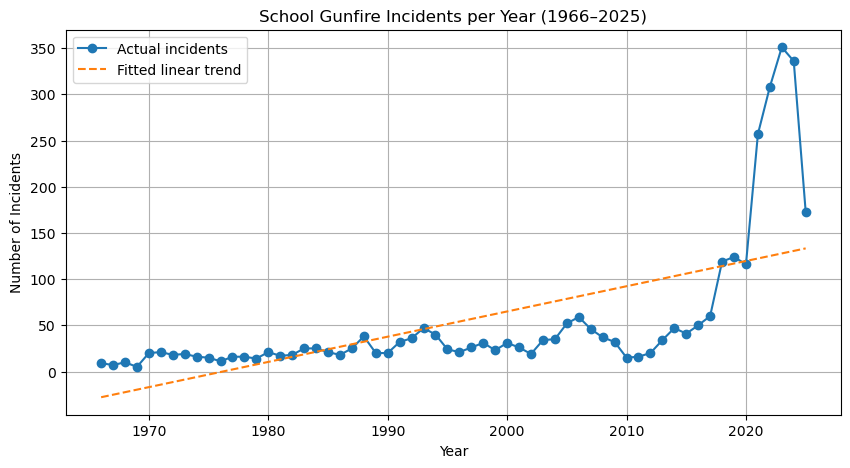

Saved yearly trend plot to: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\Regular codes with Jupyter-2\yearly_trend.png


In [8]:
print("\n=== Q1: Temporal Trends (Yearly) ===")
yearly = analyze_temporal_trends(incident_prepared)

pd.set_option("display.max_rows", None)
yearly

yearly_with_model = fit_time_trend_model(yearly)

# Save yearly results with model predictions
os.makedirs(output_dir, exist_ok=True)
yearly_csv_path = os.path.join(output_dir, "yearly_incidents_sklearn_from_notebook.csv")
yearly_with_model.to_csv(yearly_csv_path, index=False)
print(f"\nSaved yearly incidents + model predictions to: {yearly_csv_path}")

plot_yearly_trend(yearly_with_model, output_dir)


=== Q2: State-Level Patterns ===

Saved state-level incidents to: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\Regular codes with Jupyter-2\state_incidents_sklearn_from_notebook.csv


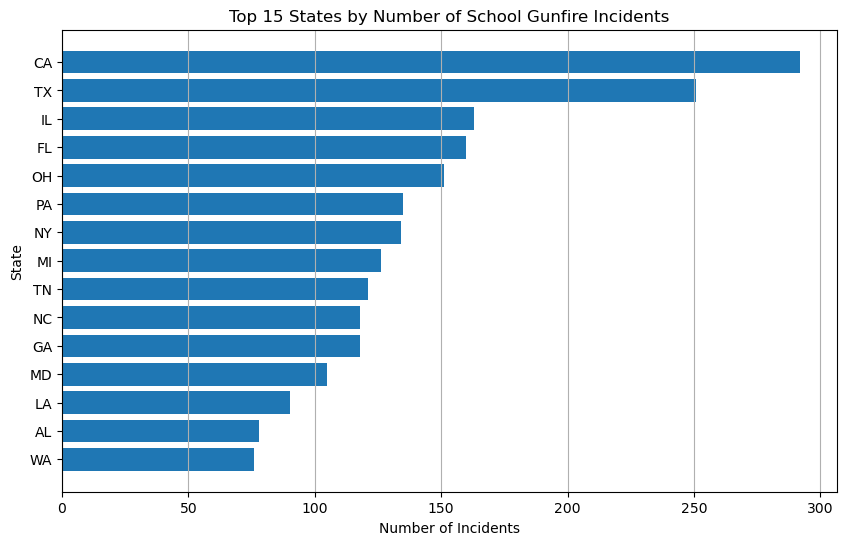

Saved state-level plot to: D:\MLProject\__Individualsheet_dataset\0a_Incident_Analysis\Regular codes with Jupyter-2\state_top_incidents.png


In [9]:
print("\n=== Q2: State-Level Patterns ===")
state_counts = analyze_state_patterns(incident_prepared)

pd.set_option("display.max_rows", None)
state_counts

state_csv_path = os.path.join(output_dir, "state_incidents_sklearn_from_notebook.csv")
state_counts.to_csv(state_csv_path, index=False)
print(f"\nSaved state-level incidents to: {state_csv_path}")

plot_state_topN(state_counts, output_dir, top_n=15)

### Interpretation – Temporal Trends

The yearly incident counts and linear regression model show a clear upward trend in school gunfire incidents from 1966 to 2025. Early decades have relatively low values (5–20 incidents), but recent decades show substantially higher frequencies. The fitted model indicates an average increase of approximately **2.7 incidents per year**, confirming a strong long-term upward trend.
### Interpretation – State-Level Patterns

State-level aggregation reveals large geographic disparities. California and Texas report the highest incident totals, followed by Illinois, Florida, Ohio, and Pennsylvania. Many smaller states show minimal incident activity. This uneven geographic distribution highlights regional concentration and the need for tailored policy approaches.
